<a href="https://colab.research.google.com/github/Mthandazo42/identifymypet/blob/master/identify_my_pet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Basic Image classfication, using the PETS dataset which was prepared by OXFORD. This notebook is meant to illustrate the power and easy usability of the fastai library. This practise exercise is inspired by the Deep learning for coders course by Jeremy Howard


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Step One: 
We will start by doing all necessary imports used for this practise exercise. 

In [0]:
from fastai import *
from fastai.vision import *
import numpy as np
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt

Step 2a: In this step we will download our dataset using the untar_data() method, which comes as a util tool in the fastai library. This method expects us to pass in the url in which to download the dataset (archived in a .tar.gz format) from. The return type of this  method is the path where the dataset will be stored. Lucky for us fastai has some already available urls which point to the dataset we will use for this practise exercise

In [0]:
path = untar_data(URLs.PETS)
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

Step 2b: The output from the previous command show us the path of our dataset, we can use the ls() method to list the directories of our dataset or use the command line !ls {path} which will give us the same output

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

As we can see from the above, we have a folder which contains annotations, and another one which contains images, the next step will be to generate two path, path_images, path_annotations.

In [0]:
path_images = path/'images'
path_annotations = path/'annotations'

Step 3a: In this step we will extract the images files from their main directory using the get_image_files() method which is also provided to us by fastai, thanks to fastai our job is not a heavy load

In [0]:
fnames = get_image_files(path_images)
fnames[:6]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_180.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_setter_186.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pug_106.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_87.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_183.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_setter_57.jpg')]

Step 3b: As we can see the from the above output, the image files are named in this format, breed_imagesnumber.jpg, therefor to obtain images name we can use regex matching since we know the format of the file names. Using the expression r'/([^/]+)_\d+.jpg$' we can accurately obtain the image names from the image files. The question that might arise from you right now is do we need to write a function which will perform the regex for each file? Guess what, we have everything we need inside fastai, we will use one of the dataprocessing factory methods called ImageDataBunch which produces a well formated databunch that we can feed to our model. since we are obtain names using regex matching we will use ImageDataBunch.from_name_re() inside the method we will parse path_image, fname, the regex match we want to use, define the transformations which will applied to the images to normalize them and lastly the size. For transformations we will use get_transforms() which is similar to combining multiple transformations in pytorch. For this practise we will use be using transfer learning, using resnet34 as our core model, hence our size will be 224 which is compatible with resnet34

In [0]:
np.random.seed(42)
pat = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_images, fnames, pat, ds_tfms=get_transforms(), size=224)

Please take note that, that the very useful ImageDataBunch will also divide a certain amount of our data and reserve it to be the validation set. Now lets review the contents of the data

In [0]:
print(data)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
miniature_pinscher,Russian_Blue,saint_bernard,Bombay,British_Shorthair
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
newfoundland,Persian,yorkshire_terrier,Russian_Blue,Egyptian_Mau
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None


As we can see from the above our ImageDataBunch is ready to dive into our model, we can use data.classess (to view the classes present in our dataset) and data.show_batch() to view a single batch of our train image data. Let's try it right away

In [0]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


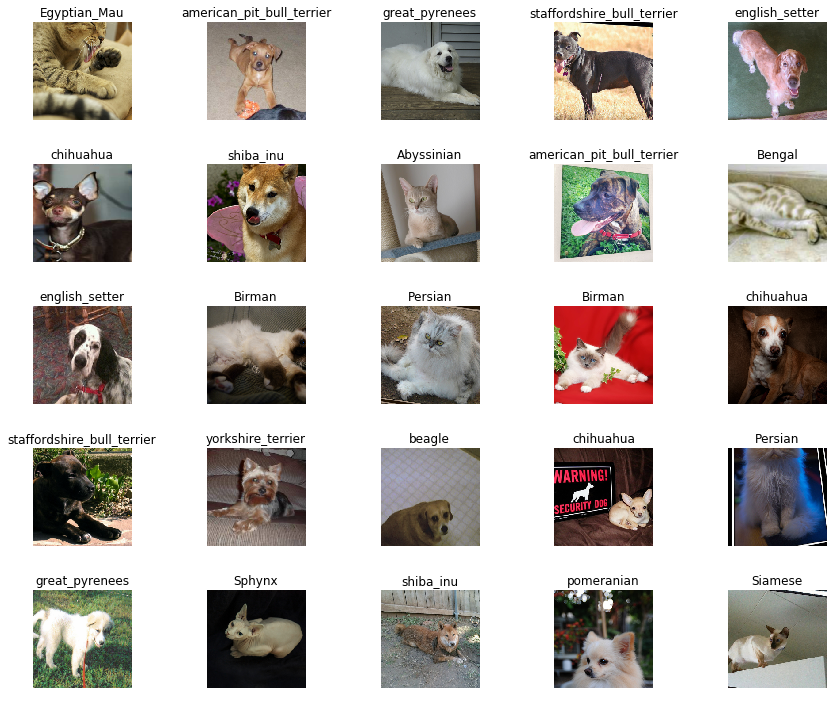

In [0]:
data.show_batch(row=3, figsize=(12,10))

In [0]:
data.c

37

Using data.c we can view the number of possible outcomes, in our case we have 37. This means once the training step is complete when we seek our model to do a prediction it will choose between the 37 classes and find the closest to the object given to it to predict. The next step is the learning period, in this step we will use cnn_learner() which is a method that takes in as input the clean databunch, model to use for the transfer learning and metrics. 

In [0]:
learner = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 115126267.55it/s]


Step 4: Now that we have defined our neural network as learner its time to start training. To start the process we will use on very useful method called fit_one_cycle(number of cycles) which seems to work well.

In [0]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.413440,0.316790,0.895129,01:47
1,0.571852,0.234612,0.912720,01:47
2,0.356075,0.205530,0.931664,01:47
3,0.271737,0.203666,0.928281,01:47


From the above, results we can see that our accuracy was increasing in the first the 3 epochs, when we reach the 4th epoch our accuracy drops down. This shows that we may have made an over kill in the fitting stage. Before we start optimizing the model, lets save the current state of the model and fine tune the whole network.

In [0]:
learner.save('trial')

Step 6: Now its high time we analyse our model and see what went wrong. We will use another awesome method called ClassificationInterpretation.from_learner( ) which will enable us to see the top loses we obtained, the confusion matrix as well as the most confused from our network

In [0]:
interp = ClassificationInterpretation.from_learner(learner)

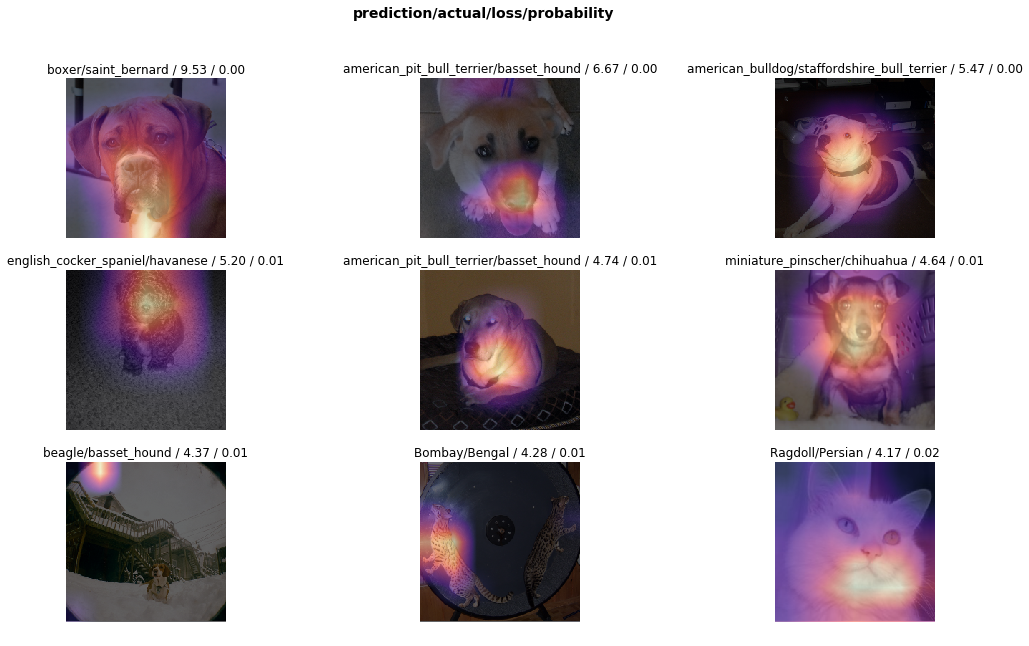

In [0]:
interp.plot_top_losses(9, figsize=(18, 10))

From the above plot we can see that even though our model was wrong in the above pets, it was not confident at all in those predictions, which indicates that its performing well. Now let's observe the confusion matrix and the most confused.

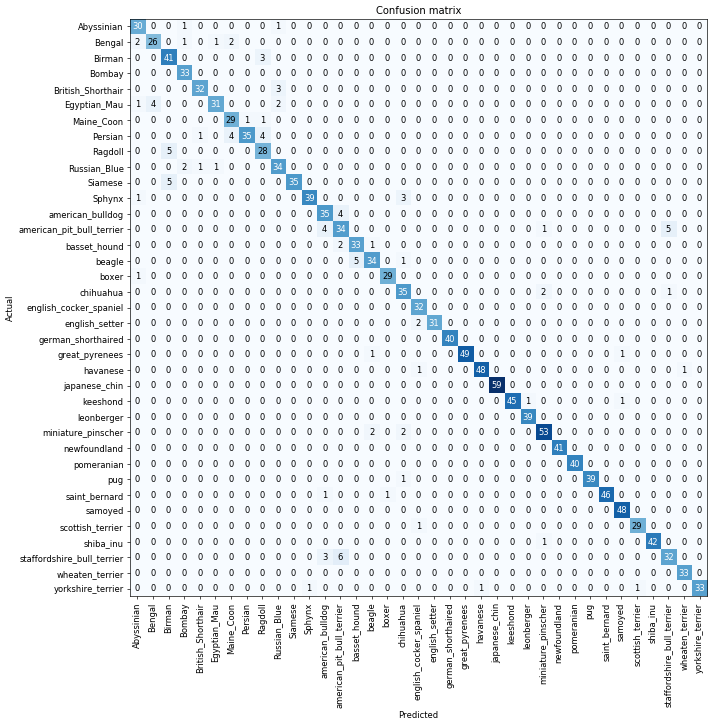

In [0]:
interp.plot_confusion_matrix(figsize=(14, 12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Ragdoll', 'Birman', 5),
 ('Siamese', 'Birman', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('beagle', 'basset_hound', 5),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Persian', 'Maine_Coon', 4),
 ('Persian', 'Ragdoll', 4),
 ('american_bulldog', 'american_pit_bull_terrier', 4),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('Birman', 'Ragdoll', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Sphynx', 'chihuahua', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Bengal', 'Maine_Coon', 2),
 ('Egyptian_Mau', 'Russian_Blue', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('basset_hound', 'american_pit_bull_terrier', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('miniature_pinscher', 'beagle', 2),
 ('miniature_pinscher', 'chihuahua', 2)]

From the above results we can conclude that our model needs a lot of optimizations for it to be better. In the following step we will unfreeze the model back to its initial state and run one epoch and try to identify the learning rate to use for us to obtain the maximum accuracy

In [0]:
learner.unfreeze()

In [0]:
learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.543692,0.321317,0.894452,01:52


From the above we can see that our model had overfitted hence the poor accuracy right now. Lets load the saved model and find the learning rate

In [0]:
learner.load('trial')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
english_setter,pug,saint_bernard,german_shorthaired,english_setter
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
keeshond,newfoundland,pug,saint_bernard,english_cocker_spaniel
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3,

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


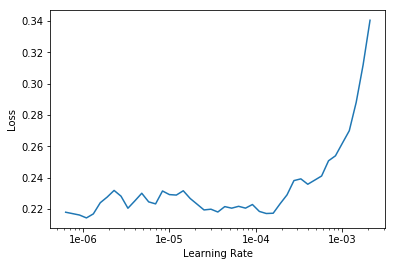

In [0]:
learner.recorder.plot()

From the above we can see that our loss started to increase when the learning rate was crossed 1e-04, now lets adjust the learning rate and make sure it does not go beond that value. From the above plot we can also see that there was steep reduction in loss from 1e-05. Now lets fit the model and run only 2 epochs and make sure the learning rate is between 1e-05 and 1e-04

In [0]:
learner.unfreeze()
learner.fit_one_cycle(2, max_lr=slice(1e-05,1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.237075,0.196041,0.934371,01:52
1,0.192949,0.178250,0.934371,01:53


Yeey, we hit a higher accuracy, now we can save our final model and begin building our web applications for predictions :)

In [0]:
learner.export

<bound method Learner.export of Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
english_setter,pug,saint_bernard,german_shorthaired,english_setter
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
keeshond,newfoundland,pug,saint_bernard,english_cocker_spaniel
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1)

In [0]:
learner.export('/gdrive/My Drive/Panda/export.pkl')